In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../../wave_cluster")
import wave_cluster as wc
%load_ext autoreload
%autoreload 2

# Data

In [2]:
# US state level demographics and Covid-19 Time-Series data (# new cases every day)
demographics = pd.read_csv("data/us_demographics.csv", index_col = 0)
data = pd.read_csv("data/us_state_daily.csv", index_col = 0)

# dropping the first 45 days for unreliable data 
data = data.iloc[45:,:]

# and dropping a few of the territories with irregular data
dr = ['US_VI', 'US_MP', 'US_GU', 'US_AS']
data = data.drop(dr, axis = 1)

# Normalization of each locations time-series to be cases per 100,000 persons
population = demographics.loc[data.columns,"population"]
norm_data = data.apply(lambda x: x/population[x.name])
data = norm_data * 100000 # cases per 100,000

# Windowed average smoothing of each time-series 
# Using 7 day average with 3 days in front and behind burrent time-stamp
front = 3
back = 3
smooth_data = wc.window_average(data.to_numpy(), front = front, back = back)

# fix the index
smoothed_index = data.index[front:-back - 1]
data = pd.DataFrame(smooth_data, index = smoothed_index, columns = data.columns)

# remove any negative entries (reporting errors still present after smoothing)
data[data < 0] = 0

# there are a few crazy spikes left over which I beleive can be attributed to 
# reporting error. I will average these out, hopefully without loss.
idd = data.columns.get_loc("US_DC")
data.iloc[565, idd] = (data.iloc[564, idd] + data.iloc[566, idd])/2

idd = data.columns.get_loc("US_MO")
mo_col = data.loc[:,"US_MO"].to_numpy().flatten()
smooth_vec = wc.window_average(mo_col[350:420], 10,10)
data.iloc[350 + 11: 420-10,idd] = smooth_vec

Text(0, 0.5, 'infections (per 100k)')

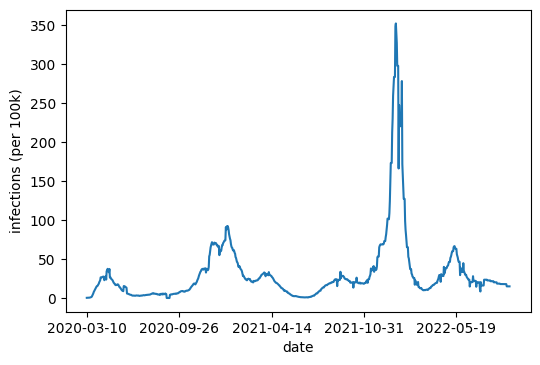

In [4]:
fix,ax = plt.subplots(dpi=100)
location = 'US_MA'
data.loc[:,location].plot(ax=ax)
ax.set_ylabel('infections (per 100k)')

# Segmentation

### 1. k-modal

The k-modal segmentation is a partition of a time-series into k segments, each of which is fitted with a unimodal regression model. Specifically, each segment is fitted with a strictly increasing isotonic regression curve, followed by a strictly decreasing one (meaning we fit 2k regression curves). The point of change between increasing and decreasing is found optimally via dynamic programming. Likewise, the global 'cut' points between segments are also found by dynamic programming. Here I use a dynamic segmentation to find global cuts and local change points in one unified process, giving the k-modal model. 

In [5]:
# data vector to fit the model with
location = 'US_MA'
data_vec = data.loc[:,location].to_numpy().flatten()

# specify a minimum segment length constraint
min_segment_size = 30

# specify the number of processors to use in parallel
cpu_count = 16

In [6]:
# Compute the error tables; for each possible time period (t1, t2), error_table1[t1,t2] shows the 
# error of fitting an increasing isotonic regression model to data_vec[t1:t2]. Likewise, error_table2 shows the 
# same result for a decreasing isotonic fit
error_table1, error_table2 = wc.compute_kmodal_error_table(data_vec, min_segment_size, cpu_count)

In [7]:
# Next use a 'dynamic segment' procedure that takes the error tables as input, and computes the optimal segmentation of
# the data. For more detail, please refer to: (INSERT)
num_segments = 10
dp = wc.dynamic_segment(error_table1, num_segments, min_segment_size, error_table2 = error_table2)

# fill segmentation error table via dp formula
dp.fill_table()
# backtrack over the table to find optimal cut points
dp.backtrack()

In [11]:
# The following specifies the cut points with data_vec[dp.cuts[0] : dp.cuts[1]] be the first 
# increasing isotonic regression segment and data_vec[dp.cuts[1] : dp.cuts[2]] being the first decreasing segment
cuts = dp.cuts
cuts

array([  0,  45, 173, 305, 356, 386, 473, 669, 738, 796, 916])

In [12]:
# we can use a unimoal fit object to generate these curves on the data
uni = wc.unimodal_fit(data_vec)
errors, fit_vec = uni.generate(cuts)

Text(0.5, 0, 'date')

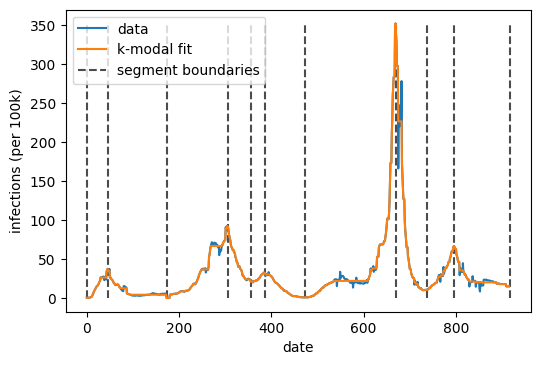

In [13]:
# and visualize the results!
fig,ax = plt.subplots(dpi = 100)
ax.plot(data_vec, label = 'data')
ax.plot(fit_vec, label = 'k-modal fit')

for c in range(len(cuts)):
    if c == 0:
        ax.vlines(x = cuts[c], ymin = np.min(data_vec), ymax = np.max(data_vec), 
                  color = 'black', linestyle = '--', alpha = 0.7, label = 'segment boundaries')
    else:
        ax.vlines(x = cuts[c], ymin = np.min(data_vec), ymax = np.max(data_vec), 
                  color = 'black', linestyle = '--', alpha = 0.7)
plt.legend()
ax.set_ylabel('infections (per 100k)')
ax.set_xlabel('date')

Text(0.5, 0, 'date')

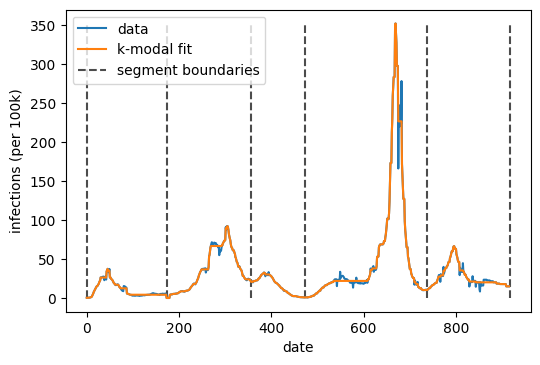

In [14]:
# AND showing only the 'waves' instead of each isotonic piece:
fig,ax = plt.subplots(dpi = 100)
ax.plot(data_vec, label = 'data')
ax.plot(fit_vec, label = 'k-modal fit')

for c in range(len(cuts)):
    if c == 0:
        ax.vlines(x = cuts[c], ymin = np.min(data_vec), ymax = np.max(data_vec), 
                  color = 'black', linestyle = '--', alpha = 0.7, label = 'segment boundaries')
    elif c % 2 == 0:
        ax.vlines(x = cuts[c], ymin = np.min(data_vec), ymax = np.max(data_vec), 
                  color = 'black', linestyle = '--', alpha = 0.7)
plt.legend()
ax.set_ylabel('infections (per 100k)')
ax.set_xlabel('date')

In [15]:
# We might also decide that we'd like to use fewer segments. This is okay and we can 
# backtrack without needing to run DP again ex)
less_segments = 6
dp.backtrack(less_segments)
dp.cuts

array([  0,  45, 173, 305, 479, 669, 916])

In [16]:
# So it's usually best to start with a large number of segments, and then 
# backtrack to smaller amounts in order to find the best choice:
many_segments = 20
dp2 = wc.dynamic_segment(error_table1, many_segments, min_segment_size, error_table2 = error_table2)
dp2.fill_table()

# Now we can use the testing method to backtrack and look at errors for each value of k 
# with a custom error function
def uni_error_func(cuts):
    errors, fit_vec = uni.generate(dp2.cuts)
    return np.linalg.norm(data_vec - fit_vec)/np.linalg.norm(data_vec)

test_errs = dp2.tester(range(2,22,2), uni_error_func)

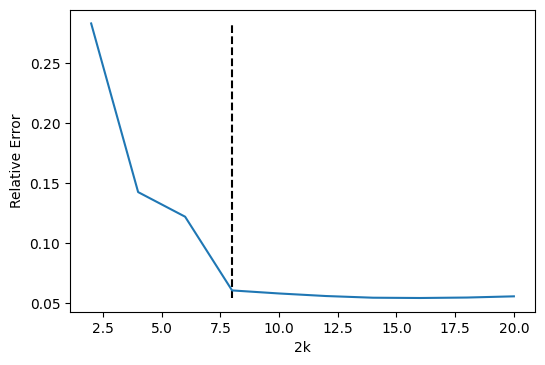

In [19]:
fig,ax = plt.subplots(dpi = 100)
x = range(2,22,2)
ax.plot(x,test_errs)
ax.set_xlabel('2k')
ax.set_ylabel('Relative Error')

elbow_point = wc.elbow(test_errs, threshold = 0.005)
ax.vlines(x=x[elbow_point], ymin = np.min(test_errs), ymax = np.max(test_errs), color = 'black', linestyle = '--')

In [23]:
dp.backtrack(x[elbow_point])
uni_cuts = dp.cuts
errors, fit_vec = uni.generate(uni_cuts)

Text(0.5, 0, 'date')

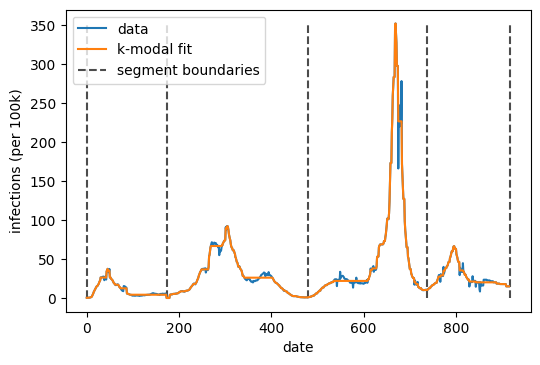

In [24]:
# AND showing only the 'waves' instead of each isotonic piece:
fig,ax = plt.subplots(dpi = 100)
ax.plot(data_vec, label = 'data')
ax.plot(fit_vec, label = 'k-modal fit')

for c in range(len(uni_cuts)):
    if c == 0:
        ax.vlines(x = uni_cuts[c], ymin = np.min(data_vec), ymax = np.max(data_vec), 
                  color = 'black', linestyle = '--', alpha = 0.7, label = 'segment boundaries')
    elif c % 2 == 0:
        ax.vlines(x = uni_cuts[c], ymin = np.min(data_vec), ymax = np.max(data_vec), 
                  color = 'black', linestyle = '--', alpha = 0.7)
plt.legend()
ax.set_ylabel('infections (per 100k)')
ax.set_xlabel('date')

### 2. SIR

 One can use a similar procedure to partition the data into k segments where each is fitted with a SIR model of disease infection. For a thorough introduction to the model please refer to https://epubs.siam.org/doi/10.1137/S0036144500371907

In [6]:
# data vector to fit the model with
location = 'US_MA'
data_vec = data.loc[:,location].to_numpy().flatten()

# Can use population 100,000 because we normalized to do so
population = 100000

# specify a minimum segment length constraint
min_segment_size = 30

# specify the number of processors to use in parallel
cpu_count = 30

In [ ]:
# Compute the error tables; for each possible time period (t1, t2), error_table[t1,t2] shows the 
# error of fitting an SIR model to data_vec[t1:t2]
error_table = wc.compute_sir_error_table(data_vec, population, min_segment_size, cpu_count=cpu_count, initialization='auto')

In [11]:
# Next use a 'dynamic segment' procedure that takes the error tables as input, and computes the optimal segmentation of
# the data. For more detail, please refer to: (INSERT)
num_segments = 10
dp = wc.dynamic_segment(error_table, num_segments, min_segment_size)

# fill segmentation error table via dp formula
dp.fill_table()
# backtrack over the table to find optimal cut points
dp.backtrack()

In [14]:
# Since we started with 10 segments we can backtrack for 
# smaller amounts to analyze the best choice of k
sir_model = wc.sir_fit(data_vec, population, initialization = 'auto')

# Using the tester method to backtrack and look at errors for each value of k 
# with a custom error function
def sir_error_func(cuts):
    errors, fit_vec, params = sir_model.generate(cuts)
    return np.linalg.norm(data_vec - fit_vec)/np.linalg.norm(data_vec)

test_errs = dp.tester(range(2,11), sir_error_func)

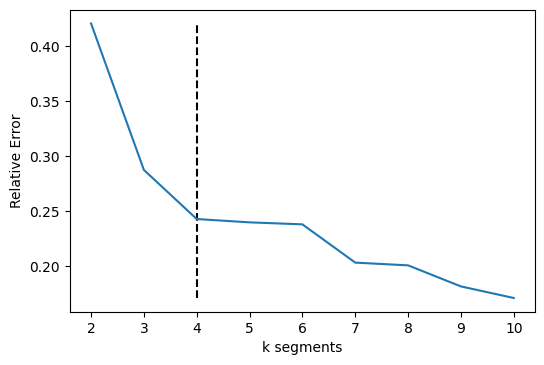

In [18]:
fig,ax = plt.subplots(dpi = 100)
x = range(2,11)
ax.plot(x,test_errs)
ax.set_xlabel('k segments')
ax.set_ylabel('Relative Error')

elbow_point = wc.elbow(test_errs, threshold = 0.005)
ax.vlines(x=x[elbow_point], ymin = np.min(test_errs), ymax = np.max(test_errs), color = 'black', linestyle = '--')

Text(0.5, 0, 'date')

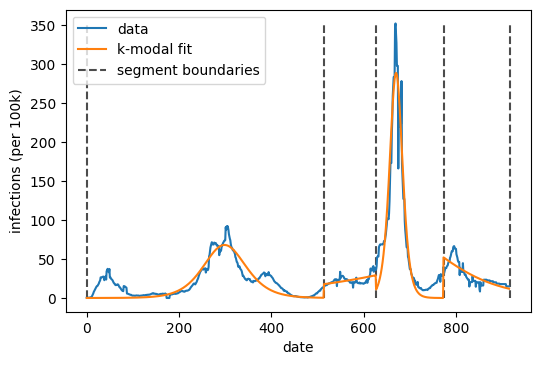

In [24]:
# and visualize the results!
chosen_k = 4
dp.backtrack(chosen_k)
errors, fit_vec, params = sir_model.generate(dp.cuts)
fig,ax = plt.subplots(dpi = 100)
ax.plot(data_vec, label = 'data')
ax.plot(fit_vec, label = 'k-modal fit')

for c in range(len(dp.cuts)):
    if c == 0:
        ax.vlines(x = dp.cuts[c], ymin = np.min(data_vec), ymax = np.max(data_vec), 
                  color = 'black', linestyle = '--', alpha = 0.7, label = 'segment boundaries')
    else:
        ax.vlines(x = dp.cuts[c], ymin = np.min(data_vec), ymax = np.max(data_vec), 
                  color = 'black', linestyle = '--', alpha = 0.7)
plt.legend()
ax.set_ylabel('infections (per 100k)')
ax.set_xlabel('date')

# Dynamic Time Warp

Now that we have segments we'd like to be able to compare them. The problem is that these segments are varying in size and are usually offset in time. To work with them and avoid these issues we use dynamic time warping 

In [71]:
# first lets choose two segments to compare
seg1 = data.loc[:,'US_MA'][173:479].to_numpy()
seg2 = data.loc[:,'US_RI'][150:425].to_numpy()

# normalize them by the max of the larger 
normy = max(seg1.max(), seg2.max())
seg1 /= normy
seg2 /= normy

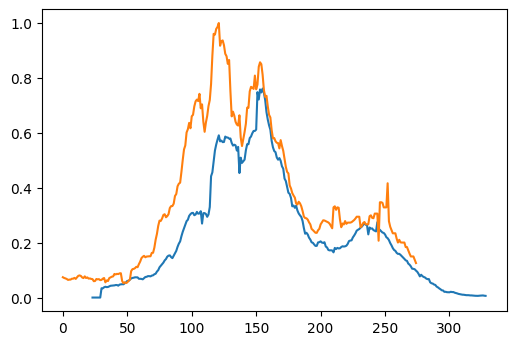

In [72]:
segap1 = np.zeros(23)
segap2 = np.zeros(79 - 25)
segap1[:] = np.nan
segap2[:] = np.nan
seg1_plot = np.concatenate((segap1, seg1))
seg2_plot = np.concatenate((seg2, segap2))
fig,ax = plt.subplots(dpi = 100)
#seg1.plot(x = range(23, 479 - 173 + 23), ax = ax)
#seg2.plot(x = range(250), ax = ax)
ax.plot(seg1_plot, label = 'MA segment')
ax.plot(seg2_plot, label ='RI segment')

In [75]:
# as we can see, the segments are of different length and appear offset in time
# So we can use DTW to compare these!

# First we'll need to define a distance that DTW can use within its dynamic program:
# This function will return the (non-normalized) l2 distance -- I'll normalize its results later
def d(x,y):
    return np.linalg.norm(x-y)

# then we can compute results from dtw
cost, align, cost_matrix = wc.dtw(seg1, seg2, distance = d)

In [86]:
cost

15.410502799228356

Text(0.5, 1.0, 'visualized alignment')

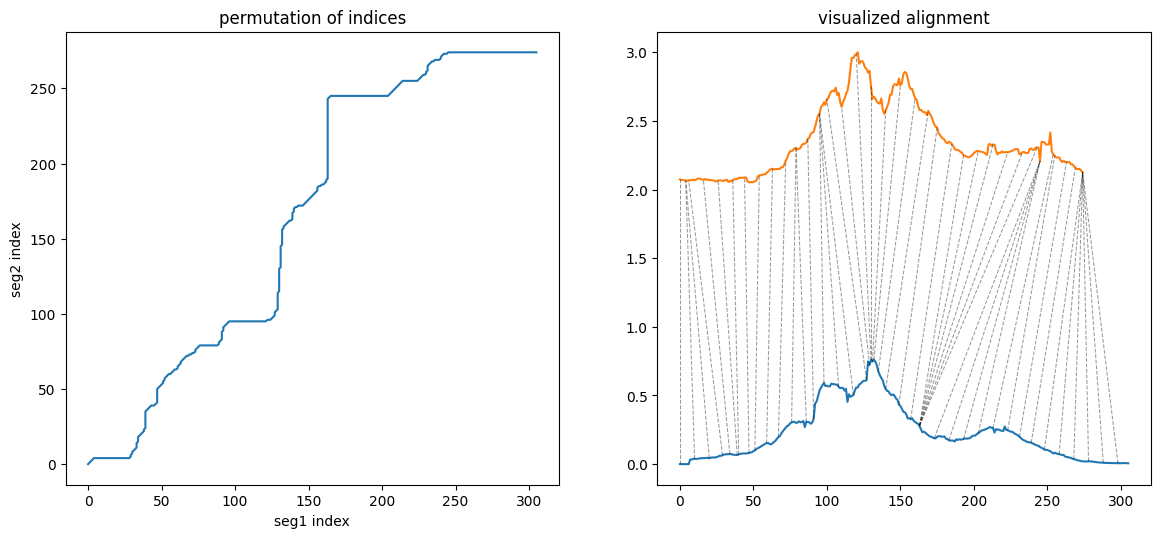

In [102]:
# and then plot the results
fig,ax = plt.subplots(1,2, figsize = (14,6), dpi = 100)
wc.permutation_plot(align, ax = ax[0])
wc.align_plot(seg1, seg2, align, offset = 2, skips = 10, ax = ax[1])
ax[0].set_title('permutation of indices')
ax[0].set_ylabel('seg2 index')
ax[0].set_xlabel('seg1 index')
ax[1].set_title('visualized alignment')

In [104]:
# we can also enforce the alignment to be more strict, enforcing 
# multiplicative permutation constrants as introduced in https://ieeexplore.ieee.org/document/1163055
# Or additive permutation constraints as discussed in https://arxiv.org/abs/2111.13314

# here and throughout I will only use the multiplicative constraints
mp = [5,5,1]
ap = [0,0,0]
cost, align, cost_matrix= wc.dtw(seg1, seg2, distance = d, mult_penalty = mp, add_penalty = ap)

Text(0.5, 1.0, 'visualized alignment')

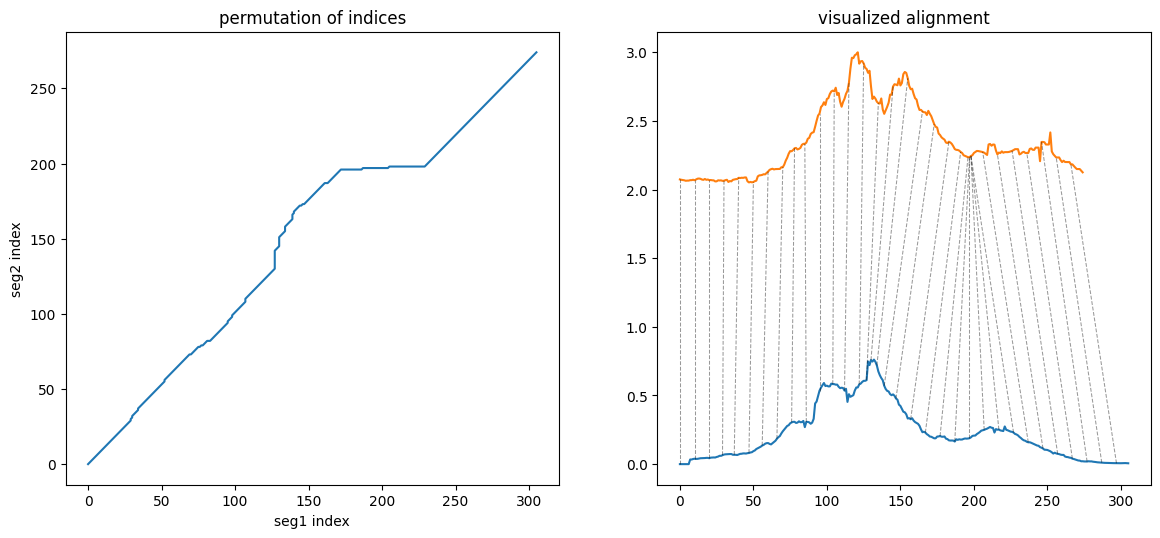

In [105]:
# and then plot the results
fig,ax = plt.subplots(1,2, figsize = (14,6), dpi = 100)
wc.permutation_plot(align, ax = ax[0])
wc.align_plot(seg1, seg2, align, offset = 2, skips = 10, ax = ax[1])
ax[0].set_title('permutation of indices')
ax[0].set_ylabel('seg2 index')
ax[0].set_xlabel('seg1 index')
ax[1].set_title('visualized alignment')